<a href="https://colab.research.google.com/github/NerdyWithZainab/Malaria-Diagnosis/blob/main/Malaria_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf # Creating a model
import numpy as np # Computation of math calculations
import matplotlib.pyplot as plt # Plotting charts
import tensorflow_datasets as tfds # Loading datasets from TensorFlow
from tensorflow.keras.layers import Conv2D, MaxPool2D , Dense, InputLayer, Flatten , BatchNormalization, Input, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, CSVLogger,LearningRateScheduler, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.regularizers import L2,L1
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from os import name

In [2]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'),TrueNegatives(name = "tn"), FalseNegatives(name= "fn"), BinaryAccuracy(name="accuracy"),Precision(name="precision"), Recall(name="recall"), AUC(name="auc")]

In [3]:
dataset , dataset_info = tfds.load('malaria', with_info = True, as_supervised=True, shuffle_files=True, split=['train'],)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.LRN1KT_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
def splits(dataset, TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  DATASET_SIZE = dataset_info.splits['train'].num_examples
  train_dataset = dataset.take((int(TRAIN_RATIO * DATASET_SIZE)))

  val_test_dataset = dataset.skip((int(TRAIN_RATIO * DATASET_SIZE)))
  val_dataset = val_test_dataset.take((int(VAL_RATIO * DATASET_SIZE)))

  test_dataset = val_test_dataset.skip((int(VAL_RATIO * DATASET_SIZE)))
  return train_dataset, val_dataset, test_dataset

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
#dataset = tf.data.Dataset.range(10)
train_dataset , val_dataset , test_dataset = splits(dataset[0], TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), np.int64(0))] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0,

## Data Visualization

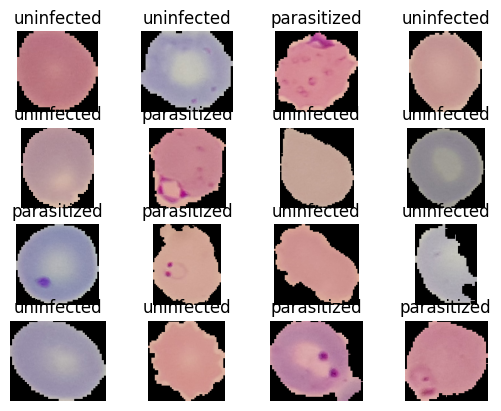

In [6]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

## Data Processing

In [7]:
IM_SIZE = 224
def resize_rescale(image,label):
  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255.0 , label

In [8]:
def augment(image,label):

  image, label = resize_rescale(image,label)
  image = tf.image.rot90(image)
  image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)

  return image, label

In [9]:
#test_dataset = test_dataset.map(resize_rescale) # Redundant, handled in batching pipeline

In [10]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(151, 115, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.map(augment).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
val_dataset = val_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
test_dataset = test_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model Creation

In [14]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

    Conv2D(filters = 6 , kernel_size= 5, strides = 1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters = 16 , kernel_size= 5, strides = 1, padding='valid', activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(1000, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │    44,945,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,052,561 (171.86 MB)

 Trainable params: 45,050,317 (171.85 MB)

 Non-trainable params: 2,244 (8.77 KB)

In [15]:
model.compile(optimizer= Adam(learning_rate = 0.01), loss= BinaryCrossentropy(), metrics = metrics)

In [16]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 20 , verbose = 1)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.6326 - auc: 0.6794 - fn: 2004.8435 - fp: 1943.3188 - loss: 0.6927 - precision: 0.6364 - recall: 0.6322 - tn: 3575.5000 - tp: 3532.2854 - val_accuracy: 0.5731 - val_auc: 0.6990 - val_fn: 193.0000 - val_fp: 983.0000 - val_loss: 1.1797 - val_precision: 0.5493 - val_recall: 0.8613 - val_tn: 381.0000 - val_tp: 1198.0000
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.6403 - auc: 0.6896 - fn: 2373.1506 - fp: 1692.7333 - loss: 0.6349 - precision: 0.6585 - recall: 0.5916 - tn: 3825.9434 - tp: 3164.1204 - val_accuracy: 0.5532 - val_auc: 0.6001 - val_fn: 943.0000 - val_fp: 288.0000 - val_loss: 0.6835 - val_precision: 0.6092 - val_recall: 0.3226 - val_tn: 1075.0000 - val_tp: 449.0000
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 57s 83ms/step - accuracy: 0.6343 - auc: 0.6856 - fn: 2399.9912 - fp: 1534.0479 - loss: 0.6319 - precision: 0.6634 - recall: 0.5551 - tn: 3984.7478 - tp: 3137.1609 - val_accuracy: 0.5561 - v

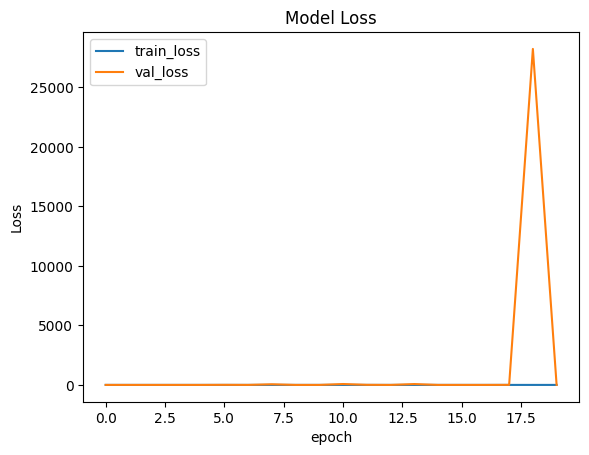

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

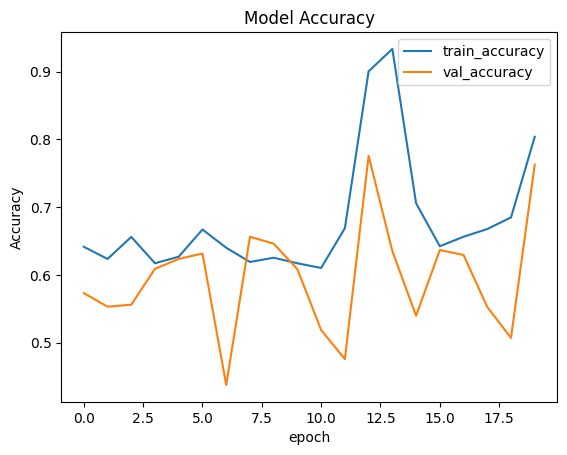

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [19]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.7573 - auc: 0.8440 - fn: 53.0795 - fp: 291.7841 - loss: 2.8185 - precision: 0.6932 - recall: 0.9246 - tn: 422.0000 - tp: 656.1591


[3.2360780239105225,
 1253.0,
 572.0,
 825.0,
 107.0,
 0.7537177801132202,
 0.6865753531455994,
 0.9213235378265381,
 0.8392772078514099]

In [20]:
def parasite_or_not(x):
  if(x > 0.5) :
    return 'Parasite'
  else:
    return 'Not Parasite'

In [21]:
parasite_or_not(model.predict(test_dataset.take(25))[0][0])

25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step


'Parasite'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


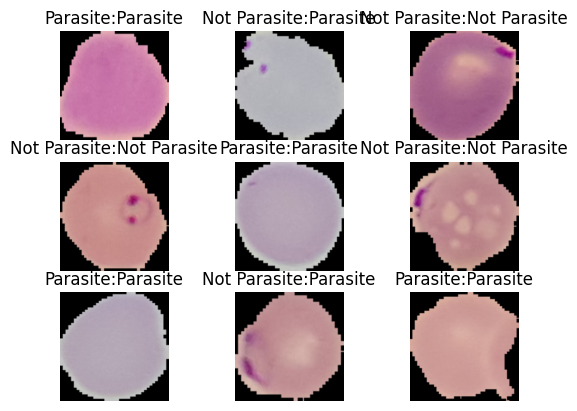

In [22]:
for i , (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title((parasite_or_not(label.numpy()[0])) + ":" + parasite_or_not(model.predict(image)[0][0]))
  plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


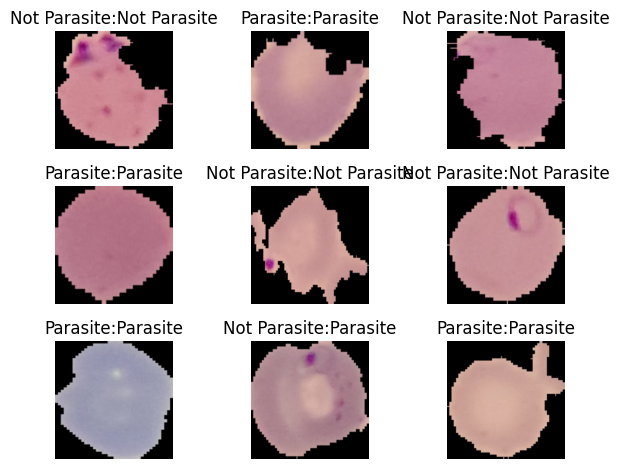

In [23]:
for images, labels in test_dataset.take(1): # Take one batch
  for i in range(min(len(images), 9)): # Iterate through up to 9 images in the batch
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title((parasite_or_not(labels.numpy()[i])) + ":" + parasite_or_not(model.predict(tf.expand_dims(images[i], axis=0))[0][0]))
    plt.axis('off')
plt.tight_layout()
plt.show()

# Functional API

In [24]:
func_input = Input(shape = (IM_SIZE,IM_SIZE,3), name = 'Input_Image')
x = Conv2D(filters = 6 , kernel_size = 3, strides = 1, padding ='valid',activation = 'relu' )(func_input)
x = BatchNormalization()(x)
x =MaxPool2D(pool_size = 2 , strides = 2) (x)

x = Conv2D(filters = 16 , kernel_size = 3, strides = 1, padding='valid',activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2 , strides = 2)(x)



func_output = Dense(1,activation = 'sigmoid')(x)
feature_extractor_model = Model(func_input, func_output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 109, 109, 1)    │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,109 (4.33 KB)

 Non-trainable params: 44 (176.00 B)

In [81]:
func_input = Input(shape = (IM_SIZE,IM_SIZE,3), name = 'Input_Image')
x = feature_extractor_model(func_input)

x = Flatten()(x)

x = Dense(1000, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
# Removed the redundant final Dense layer
func_output = Dense(1, activation='sigmoid')(x)

lenet_model = Model(func_input, func_output, name="Lenet_Model")
lenet_model.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Feature_Extractor (Functional)  │ (None, 109, 109, 1)    │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 11881)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1000)           │    11,882,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,987,754 (45.73 MB)

 Trainable params: 11,985,510 (45.72 MB)

 Non-trainable params: 2,244 (8.77 KB)

#Callbacks

In [26]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1,logs["loss"]))
  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1,logs))

#CSVLogger

In [27]:
csv_callback = CSVLogger('logs.csv',separator=',',append=True)

#EarlyStopping

In [77]:
es_callback = EarlyStopping(monitor='val_loss',min_delta = 0,patience=3, verbose=1, mode='auto',baseline=None, restore_best_weights=False)

###LearningRateScheduler

In [29]:
def scheduler(epoch,lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

#ModelCheckpointing

In [30]:
checkpoint_callback = ModelCheckpoint('checkpoints.keras', monitor='val_loss',verbose=0,save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')

#ReduceLearningRateOnPlateau

In [78]:
plateau_callback = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=2, verbose=1)

#Custom Metric Class

In [52]:
class CustomAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name='Custom_Accuracy', FACTOR=1, **kwargs):
    super(CustomAccuracy, self).__init__(name=name, **kwargs)
    self.FACTOR = FACTOR
    self.correct_predictions = self.add_weight(name='correct_predictions', initializer='zeros')
    self.total_samples = self.add_weight(name='total_samples', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Directly compute binary accuracy using TensorFlow operations
    binary_predictions = tf.round(y_pred)
    correct_predictions = tf.cast(tf.equal(y_true, binary_predictions), tf.float32) * self.FACTOR
    self.correct_predictions.assign_add(tf.reduce_sum(correct_predictions))
    self.total_samples.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

  def result(self):
    return self.correct_predictions / self.total_samples

  def reset_states(self):
    self.correct_predictions.assign(0.)
    self.total_samples.assign(0.)

#Custom Metric Method (without parameters)

In [33]:
def custom_accuracy(y_true,y_pred):
  bce = BinaryCrossentropy()
  binary_accuracy = tf.keras.metrics.binary_accuracy(y_true,y_pred ,threshold=0.5)
  return binary_accuracy(y_true,y_pred)

#Custom Metric Method (with parameters)

In [34]:
def custom_accuracy(FACTOR):
  def metric(y_true,y_pred):
    bce = BinaryCrossentropy()
    binary_accuracy = tf.keras.metrics.binary_accuracy(y_true,y_pred ,threshold=0.5)
    return binary_accuracy * FACTOR
  return metric

#Custom Loss Class

In [49]:
FACTOR = 1
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self,FACTOR):
    super(CustomBCE,self).__init__()
    self.FACTOR = FACTOR
  def call(self,y_true,y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true,y_pred)* self.FACTOR

#Custom Loss Method (without parameters)

In [36]:
def custom_bce(y_true,y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true,y_pred)

#Custom Loss Method (with parameters)

In [37]:
FACTOR = 1
def custom_bce(FACTOR):
  def loss(y_true,y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true,y_pred)* FACTOR
  return loss

In [82]:
lenet_model.compile(optimizer= Adam(learning_rate = 0.01), loss= CustomBCE(FACTOR), metrics = ['binary_accuracy'])

In [83]:
history = lenet_model.fit(train_dataset, validation_data = val_dataset, epochs = 5 , verbose = 1, callbacks = [plateau_callback])

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 72s 97ms/step - binary_accuracy: 0.8769 - loss: 0.3585 - val_binary_accuracy: 0.5042 - val_loss: 752.1742 - learning_rate: 0.0100
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 92ms/step - binary_accuracy: 0.5019 - loss: 0.6952 - val_binary_accuracy: 0.5034 - val_loss: 64421.7969 - learning_rate: 0.0100
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - binary_accuracy: 0.4999 - loss: 0.6944 - val_binary_accuracy: 0.5056 - val_loss: 94179.1016 - learning_rate: 0.0100
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 64s 93ms/step - binary_accuracy: 0.5015 - loss: 0.6939 - val_binary_accuracy: 0.5034 - val_loss: 84027.3984 - learning_rate: 0.0100
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - binary_accuracy: 0.4959 - loss: 0.6937 - val_binary_accuracy: 0.5071 - val_loss: 19267.1562 - learning_rate: 0.0100


In [55]:
IM_SIZE = 244
dropout_rate = 0.3
regularization_rate = 0.01
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

    Conv2D(filters = 6 , kernel_size= 5, strides = 1, padding='valid', activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate),

    Conv2D(filters = 16 , kernel_size= 5, strides = 1, padding='valid', activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate),

    Flatten(),

    Dense(100, activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),
    Dense(10, activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),

])
feature_extractor_seq_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 240, 240, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 240, 240, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 120, 120, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 120, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 116, 116, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 116, 116, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 58, 58, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 58, 58, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │     5,382,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,386,921 (20.55 MB)

 Trainable params: 5,386,657 (20.55 MB)

 Non-trainable params: 264 (1.03 KB)

# Model Subclassing

In [56]:
class FeatureExtractor(Layer):
 def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
   super(FeatureExtractor,self).__init__()
   self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
   self.batch_1 = BatchNormalization()
   self.pool_1 = MaxPool2D(pool_size= pool_size,strides=2*strides)

   self.conv_2 = Conv2D(filters = filters*2,kernel_size = kernel_size,strides = strides,padding = padding,activation = activation)
   self.batch_2 = BatchNormalization()
   self.pool_2 = MaxPool2D(pool_size = pool_size,strides=2*strides)

 def call(self,x,training):

  x = self.conv_1(x)
  x = self.batch_1(x)
  x = self.pool_1(x)

  x = self.conv_2(x)
  x = self.batch_2(x)
  x = self.pool_2(x)

  return x
feature_sub_classed = FeatureExtractor(8,3,1,"valid","relu",2)

In [57]:
IM_SIZE = 224
func_input = Input(shape = (IM_SIZE,IM_SIZE,3), name = 'Input Image')
x = feature_sub_classed(func_input,training=False)

x = Flatten()(x)

x = Dense(1000, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1,activation = 'sigmoid')(x)
lenet_model = Model(func_input, func_output, name="Lenet_Model_Subclassed")
lenet_model.summary()

Model: "Lenet_Model_Subclassed"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor               │ (None, 54, 54, 16)     │         1,488 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1000)           │    46,657,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,763,089 (178.39 MB)

 Trainable params: 46,760,841 (178.38 MB)

 Non-trainable params: 2,248 (8.78 KB)

In [58]:
class LenetModel(Model):
 def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
   super(LenetModel,self).__init__()
   self.feature_extractor= FeatureExtractor(8,3,1,"valid","relu",2)

   self.flatten = Flatten()
   self.dense_1 = Dense(100, activation='relu')
   self.batch_1 = BatchNormalization()
   self.dense_2 = Dense(10, activation='relu')
   self.batch_2 = BatchNormalization()
   self.dense_3 = Dense(1, activation='sigmoid')

 def call(self,x,training=True):

  x = self.feature_extractor(x,training = training)
  x = self.flatten(x)
  x = self.dense_1(x)
  x = self.batch_1(x)
  x = self.dense_2(x)
  x = self.batch_2(x)
  x = self.dense_3(x)
  return x
lenet_sub_classed = LenetModel(8,3,1,"valid","relu",2)
lenet_sub_classed.summary()

Model: "lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_extractor_1             │ ?                      │   0 (unbuilt) │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#Model Training

In [59]:
lenet_sub_classed.compile(optimizer= Adam(learning_rate = 0.01), loss= BinaryCrossentropy(), metrics = ['accuracy'])

In [60]:
history = lenet_sub_classed.fit(train_dataset, validation_data = val_dataset, epochs = 5 , verbose = 1)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.6421 - loss: 0.6517 - val_accuracy: 0.5122 - val_loss: 2.6451
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 80ms/step - accuracy: 0.7302 - loss: 0.5200 - val_accuracy: 0.4966 - val_loss: 1.3181
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 63s 92ms/step - accuracy: 0.9320 - loss: 0.2049 - val_accuracy: 0.5448 - val_loss: 4.0451
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.9401 - loss: 0.1830 - val_accuracy: 0.5568 - val_loss: 22.7650
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.9444 - loss: 0.1712 - val_accuracy: 0.4377 - val_loss: 71.9137


#Custom Layers

In [61]:
class NeuralearnDense(Layer):
  def __init__(self, output_units,activation) :
    super(NeuralearnDense,self).__init__()
    self.output_units = output_units
    self.activation = activation
  def build(self,input_features_shape):
    self._weights = self.add_weight(shape = (input_features_shape[-1],self.output_units),initializer = "random_normal" ,trainable = True)
    self._biases = self.add_weight(shape = (self.output_units,), initializer = "random_normal",trainable = True)

  def call(self,input_features):
   if(self.activation == "relu"):
    return tf.nn.relu(tf.matmul(input_features,self._weights) + self._biases)
   elif(self.activation == "sigmoid"):
    return tf.math.sigmoid(tf.matmul(input_features,self._weights) + self._biases)
   else:
    return tf.matmul(input_features,self._weights) + self._biases


In [62]:
custom_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

    Conv2D(filters = 6 , kernel_size= 3, strides = 1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters = 16 , kernel_size= 3, strides = 1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    NeuralearnDense(100, activation='relu'),
    BatchNormalization(),
    NeuralearnDense(10, activation='relu'),
    BatchNormalization(),
    NeuralearnDense(1, activation='sigmoid'),
])
custom_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense                │ (None, 100)            │     4,665,700 │
│ (NeuralearnDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense_1              │ (None, 10)             │         1,010 │
│ (NeuralearnDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense_2              │ (None, 1)              │            11 │
│ (NeuralearnDense)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

##Model training

In [63]:
custom_model.compile(optimizer= Adam(learning_rate = 0.01), loss= BinaryCrossentropy(), metrics = metrics)

In [64]:
history = custom_model.fit(train_dataset, validation_data = val_dataset, epochs = 5 , verbose = 1)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 76s 101ms/step - accuracy: 0.7061 - auc: 0.7835 - fn: 1829.1232 - fp: 2119.3015 - loss: 0.5821 - precision: 0.6937 - recall: 0.7403 - tn: 4796.4580 - tp: 5068.0654 - val_accuracy: 0.6457 - val_auc: 0.7206 - val_fn: 673.0000 - val_fp: 303.0000 - val_loss: 0.6512 - val_precision: 0.7026 - val_recall: 0.5155 - val_tn: 1063.0000 - val_tp: 716.0000
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.8310 - auc: 0.9046 - fn: 778.5652 - fp: 785.1276 - loss: 0.3810 - precision: 0.8352 - recall: 0.8278 - tn: 4733.6001 - tp: 4758.6553 - val_accuracy: 0.5071 - val_auc: 0.7979 - val_fn: 1273.0000 - val_fp: 85.0000 - val_loss: 2.2924 - val_precision: 0.5833 - val_recall: 0.0855 - val_tn: 1278.0000 - val_tp: 119.0000
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9248 - auc: 0.9705 - fn: 334.3478 - fp: 508.5087 - loss: 0.2065 - precision: 0.9129 - recall: 0.9403 - tn: 5010.2563 - tp: 5202.8350 - val_accuracy: 0.5593 - val_auc:

In [96]:
epochs = 5 # Define the number of epochs
loss_fn = tf.keras.losses.BinaryCrossentropy() # Define the loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # Define the optimizer

for epoch in range(epochs):
  print(f"Epoch {epoch+1}/{epochs}")
  for step, (x_batch, y_batch) in enumerate(train_dataset):
    with tf.GradientTape() as recorder:
      y_pred = custom_model(x_batch, training=True)
      loss = loss_fn(y_batch, y_pred) # Use y_batch first for BinaryCrossentropy

    partial_derivatives = recorder.gradient(loss, custom_model.trainable_variables)
    optimizer.apply_gradients(zip(partial_derivatives, custom_model.trainable_variables))

  # Optional: Add evaluation on validation set at the end of each epoch
  # val_loss, val_accuracy = custom_model.evaluate(val_dataset, verbose=0)
  # print(f"Epoch {epoch+1} - Loss: {loss.numpy():.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


## Model Evaluation and Testing

In [65]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Visualizing Confusion Matrix

In [66]:
lenet_model.compile(optimizer= Adam(learning_rate = 0.01), loss= BinaryCrossentropy(), metrics = metrics)

In [67]:
lenet_model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.5920 - auc: 0.6126 - fn: 1250.6250 - fp: 468.0000 - loss: 0.7087 - precision: 0.6449 - recall: 0.4205 - tn: 1609.3977 - tp: 850.0000


[0.7038601040840149,
 850.0,
 468.0,
 2292.0,
 1902.0,
 0.5700290203094482,
 0.6449165344238281,
 0.3088662922382355,
 0.598628044128418]

In [68]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [69]:
# Concatenate the list of label arrays into a single numpy array
labels = np.concatenate(labels, axis=0)
print(f"Shape of labels: {labels.shape}")

Shape of labels: (2757,)


In [70]:
predicted = lenet_model.predict(test_dataset)
print(f"Shape of predicted: {predicted.shape}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step
Shape of predicted: (2757, 1)


[[1395    0]
 [1362    0]]


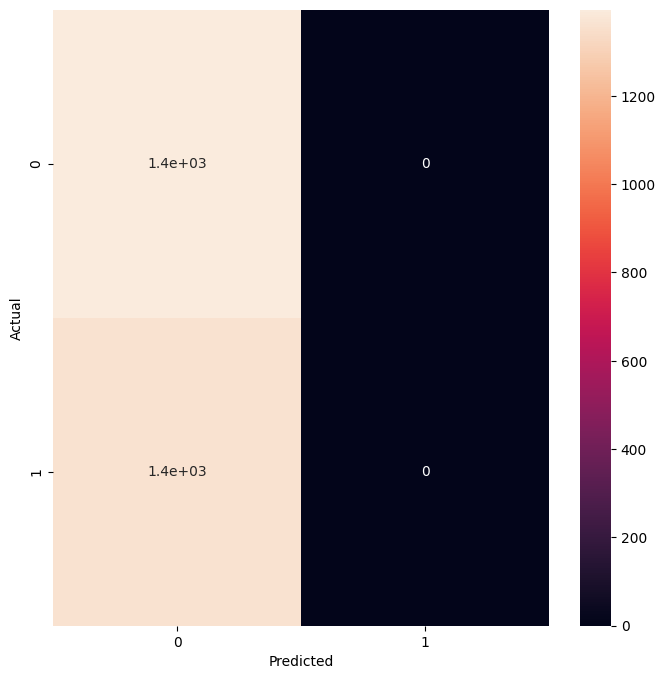

In [71]:
threshold = 0.5
cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm,annot=True,)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#ROC Plots

In [72]:
print(history.history)

{'accuracy': [0.72467041015625, 0.8838791847229004, 0.9258822202682495, 0.9341377019882202, 0.9423024654388428], 'auc': [0.8067841529846191, 0.9467145800590515, 0.9690471291542053, 0.972671627998352, 0.9784166812896729], 'fn': [3343.0, 1227.0, 640.0, 541.0, 460.0], 'fp': [3486.0, 1333.0, 994.0, 911.0, 812.0], 'loss': [0.5329231023788452, 0.29187047481536865, 0.2094183713197708, 0.19025418162345886, 0.16985023021697998], 'precision': [0.7216544151306152, 0.8802658915519714, 0.9126461148262024, 0.9200526475906372, 0.928615391254425], 'recall': [0.7299895286560059, 0.8887276649475098, 0.9419501423835754, 0.9509297013282776, 0.9582690596580505], 'tn': [8936.0, 9686.0, 10027.0, 10110.0, 10211.0], 'tp': [9038.0, 9800.0, 10385.0, 10484.0, 10563.0], 'val_accuracy': [0.6457350254058838, 0.5070780515670776, 0.559346616268158, 0.6533575057983398, 0.6352087259292603], 'val_auc': [0.7205970287322998, 0.7979468703269958, 0.7082196474075317, 0.7049725651741028, 0.61745285987854], 'val_fn': [673.0, 12

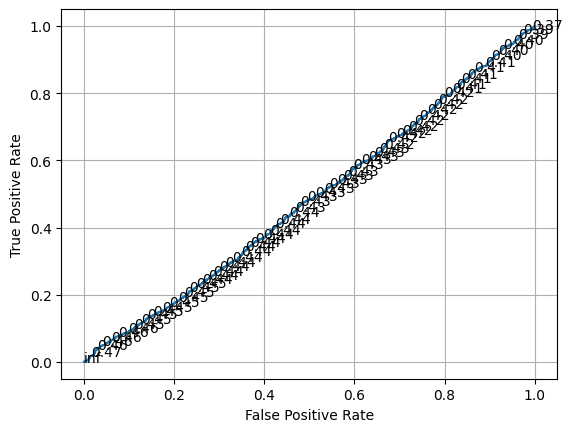

In [73]:
fp,tp,thresholds = roc_curve(labels,predicted)
plt.plot(fp,tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()
skip = 20

for i in range(0,len(thresholds),skip):
  plt.text(fp[i],tp[i],f"{thresholds[i]:.2f}")
plt.show()

#Data Preprocessing

##Data Augmentation

In [85]:
def visualize(original,augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)
  plt.title("Original")


  plt.subplot(1,2,2)
  plt.imshow(augmented)
  plt.title("Augmented")

  plt.show()

In [75]:
original_image, label = next(iter(train_dataset))

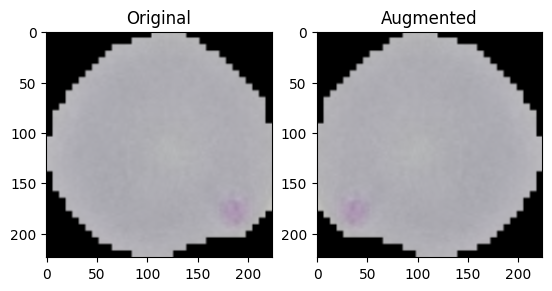

In [86]:
original_image, label = next(iter(train_dataset.unbatch().take(1)))
augmented_image = tf.image.flip_left_right(original_image)
visualize(original_image, augmented_image)

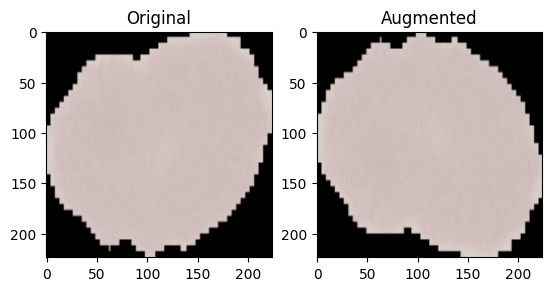

In [87]:
original_image, label = next(iter(train_dataset.unbatch().take(1)))
augmented_image = tf.image.random_flip_up_down(original_image)
visualize(original_image, augmented_image)

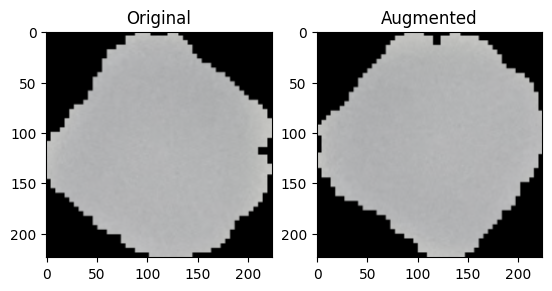

In [88]:
original_image, label = next(iter(train_dataset.unbatch().take(1)))
augmented_image = tf.image.rot90(original_image)
visualize(original_image, augmented_image)

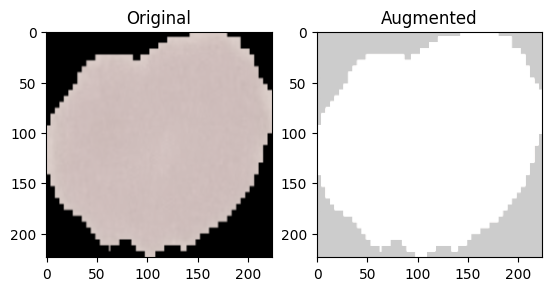

In [89]:
original_image, label = next(iter(train_dataset.unbatch().take(1)))
augmented_image = tf.image.adjust_brightness(original_image,delta = 0.8)
visualize(original_image, augmented_image)

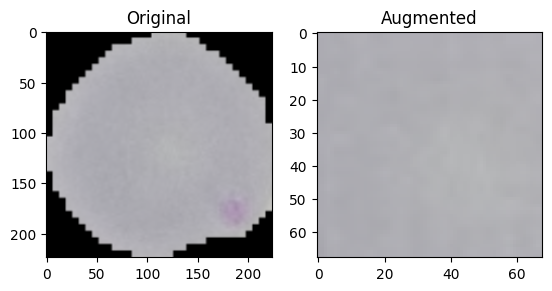

In [90]:
original_image, label = next(iter(train_dataset.unbatch().take(1)))
augmented_image = tf.image.central_crop(original_image, 0.3)
visualize(original_image, augmented_image)

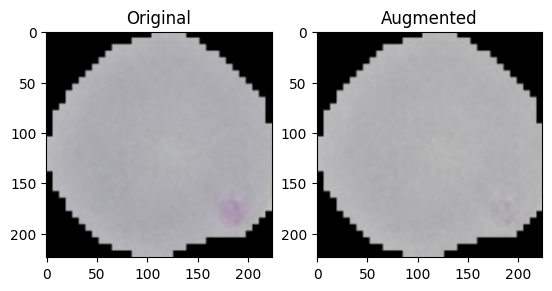

In [91]:
original_image, label = next(iter(train_dataset.unbatch().take(1)))
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor = 0.3)
visualize(original_image, augmented_image)

In [97]:
from ipywidgets import Widget
Widget.close_all()